<a href="https://colab.research.google.com/github/oguzhanolm/Tweet_Analyzer_with_Zero-Shot/blob/main/twitter_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install snscrape

In [2]:
import snscrape.modules.twitter as sntwitter
import itertools
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates

In [3]:
!pip install transformers
from transformers import pipeline,AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("emrecan/bert-base-multilingual-cased-allnli_tr")
model = AutoModelForSequenceClassification.from_pretrained("emrecan/bert-base-multilingual-cased-allnli_tr")

     |████████████████████████████████| 3.5 MB 6.9 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 6.5 MB 34.6 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [4]:
search = "near:İstanbul, within:35km"
containsList = ["ukrayna","rusya"]

candidate_labels = ['savaş', 'barış', 'doğal afet','deprem']

In [5]:
scraped_tweets = sntwitter.TwitterSearchScraper(search).get_items()

sliced_scraped_tweets = itertools.islice(scraped_tweets, 10000)

df = pd.DataFrame(sliced_scraped_tweets)

In [6]:
latin_re = re.compile(r'[^a-zA-ZfğüışöçĞÜIİŞÖÇ0-9 ]')
http_re = re.compile(r'https?[^\s]*')
usr_re = re.compile(r'@[^\s]*')
emoji_re = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

LENGTH = 15

def clean_content(data):
  data = data[(data.outlinksss == "") & (data.tcooutlinksss == "")][["date","content"]]
  data["content"] = data["content"].apply(lambda x: re.sub(http_re, '', x))
  data["content"] = data["content"].apply(lambda x: re.sub(usr_re, '', x))
  data["content"] = data["content"].apply(lambda x: re.sub(emoji_re, '', x))
  data["content"] = data["content"].apply(lambda x: re.sub(latin_re, '', x))
  data["content"] = data["content"].drop_duplicates()
  data = data[data.content != ""]
  data['content'] = data['content'].str.lower()
  data["content"] = data["content"].drop(data["content"][data["content"].map(str).map(len)<LENGTH].index)

  data = data.dropna()

  tempArr = []
  for x in data.content:
    try:
      if containsList[0] in x or containsList[1] in x:
        tempArr.append(1)
      else:
        tempArr.append(0)
    except:
      print(x)

  data["isContains"]  = tempArr

  # word_freq = new_df.content.str.split(expand=True).stack().value_counts()
  
  return data

In [7]:
def groupbyTime(data):
  containsData = data.set_index("date")
  containsData = containsData.groupby(pd.Grouper(freq='3min')).sum()

  isContains = data[data.content.str.contains("ukrayna|rusya",na=False)]

  contentData = isContains.set_index("date")
  contentData = contentData.groupby([pd.Grouper(freq='3min')]).content.sum()

  containsData['content'] = contentData

  return containsData

In [8]:
nlp=pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)

def eventDetection(data):
  resList = []
  for i in range(len(data)):

    if data['isContains'][i] > tweetMean*1.7:
      res = nlp(data['content'][i][:512] ,candidate_labels)
      max_value = max(res['scores'])
      if max_value > 0.5:
        max_index = res['scores'].index(max_value)
        resList.append([res['labels'][max_index],max_value,str(data.index[i])])

       # res = res['labels'][max_index] 
      else:
        res = "There is no Event"  
        
  return resList    
  

In [9]:
new_df = groupbyTime(clean_content(df))

In [10]:
new_df.head(5)

,isContains,content
date,,
2022-02-28 19:12:00+00:00,4,rusya ve ukrayna yazmışsın ukrayna değil amer...
2022-02-28 19:15:00+00:00,6,hocamrusya kazanırsa abd karışır türkiye batı...
2022-02-28 19:18:00+00:00,10,rusya dağılacak putinin görevi buydu rusya b...
2022-02-28 19:21:00+00:00,8,bu savaş baştan aşağı ilizyonyeminle tarihte ...
2022-02-28 19:24:00+00:00,8,batı silah yardımı yapacağını söylüyor silah...


Ortalama bahsi geçme: 5.054054054054054




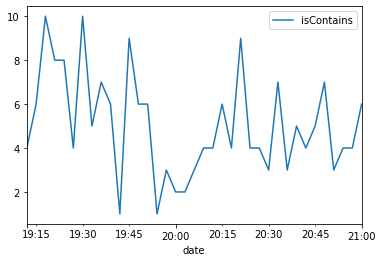

In [11]:
new_df.plot()

tweetMean = new_df.isContains.mean()
print("Ortalama bahsi geçme: " + str(tweetMean) +"\n\n")

In [12]:
eventDetection(new_df)

[['savaş', 0.5503078103065491, '2022-02-28 19:18:00+00:00'],
 ['savaş', 0.5198120474815369, '2022-02-28 19:30:00+00:00'],
 ['savaş', 0.5090082883834839, '2022-02-28 19:45:00+00:00'],
 ['savaş', 0.6996899843215942, '2022-02-28 20:21:00+00:00']]

In [ ]:
new_df.isContains.sort_values()